<a href="https://colab.research.google.com/github/mille055/Rec_Project/blob/main/notebooks/Rescrape_using_siddgood_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scraping itunes podcast descriptions and reviews

For AIPI540 recommender system module project, getting information on podcasts using similar code to what was presented in https://github.com/siddgood/podcast-recommendation-engine but also scraping reviews and authors of reviews.

In [33]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from bs4 import BeautifulSoup
import requests
import json

import pandas as pd
import numpy as np

import json
import re
import unidecode
import time
from tqdm import tqdm

#from selenium import webdriver



Getting list of podcasts from the various categories on the main apple page. 


In [35]:
CATEGORIES = {
    'arts': "https://podcasts.apple.com/us/genre/podcasts-arts/id1301",
    'business': "https://podcasts.apple.com/us/genre/podcasts-business/id1321",
    'comedy': "https://podcasts.apple.com/us/genre/podcasts-comedy/id1303",
    'education': "https://podcasts.apple.com/us/genre/podcasts-education/id1304",
    'fiction': "https://podcasts.apple.com/us/genre/podcasts-fiction/id1483",
    'government': "https://podcasts.apple.com/us/genre/podcasts-government/id1511",
    'health': "https://podcasts.apple.com/us/genre/podcasts-health-fitness/id1512",
    'history': "https://podcasts.apple.com/us/genre/podcasts-history/id1487",
    'kids_and_family': "https://podcasts.apple.com/us/genre/podcasts-kids-family/id1305",
    'leisure': "https://podcasts.apple.com/us/genre/podcasts-leisure/id1502",
    'music': "https://podcasts.apple.com/us/genre/podcasts-music/id1310",
    'news': "https://podcasts.apple.com/us/genre/podcasts-news/id1489",
    'religion_and_spirituality': "https://podcasts.apple.com/us/genre/podcasts-religion-spirituality/id1314",
    'science': "https://podcasts.apple.com/us/genre/podcasts-science/id1533",
    'society_and_culture': "https://podcasts.apple.com/us/genre/podcasts-society-culture/id1324",
    'sports': "https://podcasts.apple.com/us/genre/podcasts-sports/id1545",
    'tv_and_film': "https://podcasts.apple.com/us/genre/podcasts-tv-film/id1309",
    'technology': "https://podcasts.apple.com/us/genre/podcasts-technology/id1318",
    'true_crime': "https://podcasts.apple.com/us/genre/podcasts-true-crime/id1488"
}

In [36]:
all_podcast_links = list()

for category_url in CATEGORIES.values():
    response = requests.get(category_url, timeout=5)
    content = BeautifulSoup(response.content, "lxml")
    podcast_links = content.find('div', class_='grid3-column')
    print('now on category', category_url)
    counter = 0
    for link in podcast_links.findAll('a'):
        counter=counter+1
        all_podcast_links.append(link.get('href'))
    print('obtained ', counter, 'from that category')
    
all_podcast_links = list(set(all_podcast_links))

print('Number of podcast links', len(all_podcast_links))

with open('podcast_links.json', 'w') as outfile:
    json.dump(all_podcast_links, outfile)

now on category https://podcasts.apple.com/us/genre/podcasts-arts/id1301
obtained  240 from that category
now on category https://podcasts.apple.com/us/genre/podcasts-business/id1321
obtained  240 from that category
now on category https://podcasts.apple.com/us/genre/podcasts-comedy/id1303
obtained  240 from that category
now on category https://podcasts.apple.com/us/genre/podcasts-education/id1304
obtained  240 from that category
now on category https://podcasts.apple.com/us/genre/podcasts-fiction/id1483
obtained  240 from that category
now on category https://podcasts.apple.com/us/genre/podcasts-government/id1511
obtained  240 from that category
now on category https://podcasts.apple.com/us/genre/podcasts-health-fitness/id1512
obtained  240 from that category
now on category https://podcasts.apple.com/us/genre/podcasts-history/id1487
obtained  240 from that category
now on category https://podcasts.apple.com/us/genre/podcasts-kids-family/id1305
obtained  240 from that category
now on

Utilities for converting 10K, 5M to actual integers for the total number of star reviews, as well as cleaning the text for the titles and the episode descriptions

In [37]:
def convert_si_to_number(x):
    total_stars = 0
    if 'K' in x:
        if len(x) > 1:
            total_stars = float(x.replace('K', '')) * 1000  # convert K to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000  # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000  # convert B to a Billion
    else:
        total_stars = int(x)  # Less than 1000
    return int(total_stars)


def clean_title(t):
    t = unidecode.unidecode(t)
    t = t.replace('\n', ' ')
    t = re.sub(r'[^\w\s]', '', t)
    t = re.sub(r'\d+', '', t)
    t = t.lower()
    t = t.strip()
    return t

def clean_description(d):
    d = unidecode.unidecode(d)
    d = d.replace('\n', ' ')
    d = re.sub(r'[^\w\s]', '', d)
    d = re.sub(r'\d+', '', d)
    if re.findall(r'(.*) brought to you by.*', d):
      d = re.sub(r'brought to you by.*', '', d)
    if re.search(r'(.*) sponsored by.*', d):
      d = re.sub(r'sponsored by.*', '', d)
    d = d.lower()
    d = d.strip()
    
    return d


def clean_description_list(dlist):
    
    new_string = ""
    for d in dlist:
      d = unidecode.unidecode(d)
      d = d.replace('\n', ' ')
      d = re.sub(r'[^\w\s]', '', d)
      d = re.sub(r'\d+', '', d)
      if re.findall(r'(.*) brought to you by.*', d):
        d = re.sub(r'brought to you by.*', '', d)
      if re.search(r'(.*) sponsored by.*', d):
        d = re.sub(r'sponsored by.*', '', d)
      d = d.lower()
      d = d.strip()
      new_string = new_string + " " + d
    return new_string


Build a json object from the scraping of each link and dump into a json file for later processing

In [41]:

def build_podcast_object(link):
    try:
        response = requests.get(link, timeout=10)
        content = BeautifulSoup(response.content, "lxml")
        try:
            title = content.find('h1').find('span').text.strip()
        except AttributeError:
            title = 'NA'
        try:
            producer = content.find('h1').find('a').text.strip()
        except AttributeError:
            try:
                producer = content.find('h1').find('span', class_='product-header__identity podcast-header__identity') \
                    .text.strip()
            except AttributeError:
                producer = 'NA'
        try:
            genre = content.find('li', class_="product-header__list__item").text.strip()
        except AttributeError:
            genre = 'NA'
        try:
            description = content.find('div', class_="product-hero-desc product-hero-desc--side-bar").text.strip()
        except AttributeError:
            description = 'NA'
        try:
            num_episodes = int(content.find('div', class_="product-artwork__caption small-hide medium-show")
                               .text.strip().strip('episodes'))
        except AttributeError:
            num_episodes = 'NA'
        try:
            rating = float(content.find('span', class_="we-customer-ratings__averages__display").text.strip())
        except AttributeError:
            rating = 'NA'
        try:
            num_reviews = convert_si_to_number(content
                                               .find('div', class_="we-customer-ratings__count small-hide medium-show")
                                               .text.strip().strip('Ratings'))
        except AttributeError:
            num_reviews = 'NA'

        try:
            script_tag = content.find('script', {'name': 'schema:podcast-show', 'type': 'application/ld+json'})

            # Extract and load the JSON data
            json_data = json.loads(script_tag.string)

            # Access the features in the JSON data
            script = {'jname': json_data['name'], 
                      'jauthor': json_data['author'],
                      'jdescription': json_data['description'],        
                      'jdate_published': json_data['datePublished'],
                      'joffers': json_data['offers'],
                      'jreviews': json_data['review'],
                      'work_examples' : json_data['workExample']}


        except AttributeError:
            script = 'NA'
            jreviews = 'NA'
            work_examples = 'NA'

        image_data = 'NA'  # Initialize the variable before the try-except block

        try:
            desired_size = 400

            closest_size = None
            closest_size_url = None
            source_tag = content.find('source', {'type': 'image/webp'})

            # Get the 'srcset' attribute and split it into a list of URLs
            srcset = source_tag['srcset']
            urls = srcset.split(', ')
            
            for url in urls:
              size = int(url.split(' ')[1].rstrip('w'))
              if closest_size is None or abs(size - desired_size) < abs(closest_size - desired_size):
                closest_size = size
                closest_size_url = url.split(' ')[0]

            # Replace '.webp' with '.jpg' to get the JPG URL
            medium_jpg_url = closest_size_url.replace('.webp', '.jpg')

            response = requests.get(medium_jpg_url)
            if response.status_code == 200:
              # The image was successfully downloaded, store it as binary data
              image_data = response.content
            else:
              print(f"Failed to download image: {response.status_code}")
        except Exception as e:
              print(f"Error downloading image: {e}")




    except Exception:
        title = 'NA'
        producer = 'NA'
        genre = 'NA'
        description = 'NA'
        num_episodes = 'NA'
        rating = 'NA'
        num_reviews = 'NA'
        script = 'NA'
    podcast_object = {
        'title': title,
        'producer': producer,
        'genre': genre,
        'description': script['jdescription'],
        'num_episodes': num_episodes,
        'rating': rating,
        'num_reviews': num_reviews,
        'link': link,
        'itunes_id': link.split('/')[-1].strip('id'),
        'reviews': script['jreviews'],
        'epidsode_descriptions': [x['description'] for x in script['work_examples']],
        'ratings_lists': [(x['author'], x['reviewRating']['ratingValue']) for x in script['jreviews']],
        'image': image_data
    }
    return podcast_object


Making sure the updated scraping to get the episode description text and the reviews/reviewer pairs actually works on a single link before looping through all the links:

In [42]:
podcast_link = all_podcast_links[100]
podcast_link

'https://podcasts.apple.com/us/podcast/the-lead-with-jake-tapper/id1034974185'

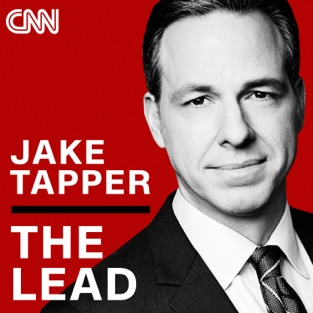

In [44]:
from IPython.display import Image
from io import BytesIO

sample_podcast = build_podcast_object(podcast_link)
# Assuming 'image_data' is the variable holding the binary data of the downloaded image
display(Image(data=sample_podcast['image']))


In [ ]:
# for review in sample_podcast['reviews']:
#     author = review['author']
#     rating = review['reviewRating']['ratingValue']
#     print(f"Author: {author}, Rating: {rating}")

Author: Nerdhoff, Rating: 5
Author: Jesusfollower9, Rating: 5
Author: 999999gd, Rating: 5
Author: Corey Lambrecht, Rating: 4
Author: Still So Much to Learn, Rating: 5
Author: Ccatd, Rating: 5
Author: AfRaven1237, Rating: 5
Author: jlm521, Rating: 5
Author: jakespex, Rating: 5
Author: Paulseywall-z, Rating: 5


In [ ]:
counter = 1
podcastObjects = list()
with open('podcast_links.json') as json_file:
    podcasts = json.load(json_file)
    for podcast_link in podcasts:
        try:
            podcast = build_podcast_object(podcast_link)
            podcastObjects.append(podcast)
            print('Completed Podcast: ' + str(counter))
            counter += 1
        except Exception:
            print('Failed on ' + podcast_link)
            counter += 1
            pass

with open('my_scrape_podcast_with_reviews.json', 'w') as outfile:
    json.dump(podcastObjects, outfile)

Completed Podcast: 1
Completed Podcast: 2
Completed Podcast: 3
Completed Podcast: 4
Completed Podcast: 5
Completed Podcast: 6
Completed Podcast: 7
Completed Podcast: 8
Failed on https://podcasts.apple.com/us/podcast/the-ringer-nfl-show/id1109282822
Completed Podcast: 10
Completed Podcast: 11
Completed Podcast: 12
Completed Podcast: 13
Failed on https://podcasts.apple.com/us/podcast/what-next-daily-news-and-analysis/id1438906889
Completed Podcast: 15
Completed Podcast: 16
Completed Podcast: 17
Completed Podcast: 18
Failed on https://podcasts.apple.com/us/podcast/ksr/id1251078708
Completed Podcast: 20
Completed Podcast: 21
Completed Podcast: 22
Completed Podcast: 23
Completed Podcast: 24
Completed Podcast: 25
Completed Podcast: 26
Completed Podcast: 27
Completed Podcast: 28
Failed on https://podcasts.apple.com/us/podcast/duncd-on-basketball-nba-podcast/id986901174
Completed Podcast: 30
Completed Podcast: 31
Completed Podcast: 32
Completed Podcast: 33
Completed Podcast: 34
Failed on https

In [ ]:
# !pip install selenium
# !apt-get update 
# !apt install chromium-chromedriver
# !pip install kora -q

In [ ]:
# def get_recent_podcast_episodes(link):
#     episode_titles = ''
#     episode_desc = ''

#     from kora.selenium import wd
#     wd.get(link)
    
#     html = wd.page_source.encode('utf-8')

#     soup = BeautifulSoup(html, 'lxml')
#     text = str(soup.find('script'))

#     try:
#         text = text.split('"workExample":')[1].split(',"aggregateRating"')[0]
#         episode_data = json.loads(text)

#         for episode in episode_data:
#             title = episode['name']
#             c_title = clean_title(title)

#             description = episode['description']
#             c_description = clean_description(description)

#             episode_titles += (c_title + " ")
#             episode_desc += (c_description + " ")

#         episode_titles = episode_titles.strip()
#         episode_desc = episode_desc.strip()

#     except Exception:
#         episode_title = np.nan
#         episode_desc = np.nan
#         print("Failed on: " + str(link))

#     return [episode_titles, episode_desc]

In [ ]:
with open('my_scrape_podcast_with_reviews.json') as json_file:
        podcasts = json.load(json_file)

podcasts_df = pd.DataFrame(podcasts)

podcasts_df = podcasts_df[['title', 'producer', 'genre', 'description', 'num_episodes',
                               'rating', 'num_reviews', 'link', 'itunes_id', 'epidsode_descriptions', 'ratings_lists']]
podcasts_df = podcasts_df.replace('NA', np.nan)
#podcasts_df = podcasts_df.dropna()

print(podcasts_df.head())

podcast_titles = list(podcasts_df['title'])
podcast_titles = [title.replace(" ", "") for title in podcast_titles]
podcast_titles = [re.sub(r'[^\w\s]', '', title) for title in podcast_titles]
is_english = [bool(re.match("^[A-Za-z9]*$", title)) for title in podcast_titles]
podcasts_df['is_english'] = is_english
podcasts_df = podcasts_df[podcasts_df.is_english == True]
podcasts_df = podcasts_df.drop(columns=['is_english'])
#podcasts_df['episode_titles'], podcasts_df['episode_descriptions'] = podcasts_df.link.apply(get_recent_podcast_episodes)


podcasts_df = podcasts_df.reset_index(drop=True)





                                               title              producer  \
0  One Strange Thing: Paranormal & True-Weird Mys...     One Strange Thing   
1                                       BibleProject  BibleProject Podcast   
2                        The Domonique Foxworth Show                  ESPN   
3                                     Hacking Humans        CyberWire Inc.   
4                                          Leader Up                  AMSC   

                     genre                                        description  \
0                  History  Paranormal, unexplainable, and uncanny stories...   
1  Religion & Spirituality  The creators of BibleProject have in-depth con...   
2                   Sports  With episodes every Tuesday and Thursday durin...   
3               Technology  Deception, influence, and social engineering i...   
4               Government  Leader Up, a podcast by the Army Management St...   

   num_episodes  rating  num_reviews  \
0   

In [ ]:
podcasts_df

,title,producer,genre,description,num_episodes,rating,num_reviews,link,itunes_id,epidsode_descriptions,ratings_lists
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,"[[RobinFerris, 5], [Pops.99, 1], [ReddEye81, 5..."
1,BibleProject,BibleProject Podcast,Religion & Spirituality,The creators of BibleProject have in-depth con...,352,4.9,15000.0,https://podcasts.apple.com/us/podcast/biblepro...,1050832450,"[David was Israel’s greatest king, but even he...","[[nina52475, 5], [simon tadesse, 5], [HMHuntle..."
2,The Domonique Foxworth Show,ESPN,Sports,With episodes every Tuesday and Thursday durin...,70,4.9,1100.0,https://podcasts.apple.com/us/podcast/the-domo...,1642566714,"[Domonique, Charlie, and Ashley Foxworth along...","[[nick ndd as mm name, 5], [StuArmy910, 5], [L..."
3,Hacking Humans,CyberWire Inc.,Technology,"Deception, influence, and social engineering i...",415,4.7,255.0,https://podcasts.apple.com/us/podcast/hacking-...,1391915810,"[Kathleen Smith, CMO from ClearedJobs.Net sits...","[[FreshDoughnuts, 5], [Jedi Wannabi, 5], [Conj..."
4,Leader Up,AMSC,Government,"Leader Up, a podcast by the Army Management St...",52,5.0,14.0,https://podcasts.apple.com/us/podcast/leader-u...,1378682853,[MSC's Mr. David Howey meets with CSM Jason C....,"[[Nolikeynewudatey, 5]]"
...,...,...,...,...,...,...,...,...,...,...,...
4032,Tales from the Stinky Dragon,Rooster Teeth,Leisure,A D&amp;D podcast from Rooster Teeth! Our brav...,101,4.9,781.0,https://podcasts.apple.com/us/podcast/tales-fr...,1563814788,"[With Asafee on his deathbed, the four Chosen ...","[[moochwaller, 5], [Sakurablossom87, 5], [Cade..."
4033,Morning Microdose,Almost 30,Education,The fact that you came across Morning Microdos...,159,5.0,187.0,https://podcasts.apple.com/us/podcast/morning-...,1639123211,[Drop in for this mind-expanding conversation ...,"[[Blue Sparrow Events, 5], [katikroy3, 5], [Ha..."
4034,Presidential,Washington Post Audio,History,The Washington Post's Presidential podcast exp...,52,4.4,3500.0,https://podcasts.apple.com/us/podcast/presiden...,1072170823,"[Students, teachers and historians reflect on ...","[[ShipShore, 5], [Cool Firework🧨, 5], [John Ve..."
4035,Badlands Cola | A Strange Audio Drama,Renee Taylor Klint,Fiction,Badlands Cola is a cinematic mystery/horror au...,17,4.6,63.0,https://podcasts.apple.com/us/podcast/badlands...,1627191206,"[Hi listeners! It's Renee, and today we're doi...","[[ck do ufk, 5], [Kat Sale, 5], [Anon8853, 5],..."


In [ ]:
### some cleanup and processing

podcasts_df2 = podcasts_df.copy()
podcasts_df2 = podcasts_df2.rename(columns = {'epidsode_descriptions':'episode_descriptions', 'rating':'avg_rating'})
podcasts_df2.episode_descriptions.apply(clean_description)
podcasts_df2 = podcasts_df2.explode('ratings_lists')
podcasts_df2[['ratings', 'users']] = podcasts_df2['ratings_lists'].apply(pd.Series)
podcasts_df2

,title,producer,genre,description,num_episodes,avg_rating,num_reviews,link,itunes_id,episode_descriptions,ratings_lists,ratings,users
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,"[RobinFerris, 5]",RobinFerris,5.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,"[Pops.99, 1]",Pops.99,1.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,"[ReddEye81, 5]",ReddEye81,5.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,"[Keyta7777, 2]",Keyta7777,2.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,"[Okkupent, 4]",Okkupent,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,"[Monijansand, 5]",Monijansand,5.0
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,"[trinityangel13, 5]",trinityangel13,5.0
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,"[Kweenkeys, 5]",Kweenkeys,5.0
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,"[JoyfulJoyfulWOG, 5]",JoyfulJoyfulWOG,5.0


In [ ]:
##fixing
podcasts_df2.rename(columns = {'ratings': 'user', 'users':'ratings'},  inplace=True)
podcasts_df2.drop(['ratings_lists'], axis=1, inplace=True)
podcasts_df2

,title,producer,genre,description,num_episodes,avg_rating,num_reviews,link,itunes_id,episode_descriptions,user,user
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,RobinFerris,5.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,Pops.99,1.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,ReddEye81,5.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,Keyta7777,2.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,Okkupent,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,Monijansand,5.0
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,trinityangel13,5.0
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,Kweenkeys,5.0
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,JoyfulJoyfulWOG,5.0


In [ ]:
podcasts_df2.columns

Index(['title', 'producer', 'genre', 'description', 'num_episodes',
       'avg_rating', 'num_reviews', 'link', 'itunes_id',
       'episode_descriptions', 'user', 'user'],
      dtype='object')

In [ ]:
podcasts_df3 = podcasts_df2.copy()

cols=pd.Series(podcasts_df3.columns)

for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

# rename the columns with the cols list.
podcasts_df3.columns=cols

podcasts_df4 = podcasts_df3.rename(columns={'user.1': 'rating'})
podcasts_df4

,title,producer,genre,description,num_episodes,avg_rating,num_reviews,link,itunes_id,episode_descriptions,user,rating
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,RobinFerris,5.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,Pops.99,1.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,ReddEye81,5.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,Keyta7777,2.0
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,1526579247,[In celebration of our new premium format—two ...,Okkupent,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,Monijansand,5.0
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,trinityangel13,5.0
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,Kweenkeys,5.0
4036,Quality Queen Control,Asha Christina,Education,"Sophistication, Psychology, Dating, and Lifest...",111,4.8,470.0,https://podcasts.apple.com/us/podcast/quality-...,1512702672,[Hey Angels!!! In today's episode of the Quali...,JoyfulJoyfulWOG,5.0


In [ ]:
podcasts_df4.to_pickle('cmm_scraped_podcasts_with_ratings.pkl')